# Technical Indicators - Forest Model

Just exploring the model now. After offloading some of the code to Python modules, the code should be much simpler.

In [36]:
# Auto reload local files
%load_ext autoreload
%autoreload 2
# Make files in src/ available to notebook
import sys
if 'src' not in sys.path:
    sys.path.insert(0, 'src')


import numpy as np

from technical_signals import TechnicalSignals, percent_change
import datastore as ds

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
from sklearn.model_selection import train_test_split

ticker = "ABBV"
#ds.download_daily_candlesticks([ticker], "2000-01-01", "2023-05-07")
data = ds.get_daily_candlesticks([ticker], "2000-01-01", "2023-06-06")[ticker]
tsigs = TechnicalSignals(data, predict_window=7)
X, y, Xy_date = tsigs.toXy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
print(Xy_date.shape)
Xy_test_date = Xy_date.iloc[-y_test.shape[0]:]
print(tsigs.signals)

(2381,)
           rsi7      rsi14      rsi30        kama  percent_price         ema  \
0           NaN        NaN        NaN         NaN            NaN         NaN   
1           NaN        NaN        NaN         NaN            NaN         NaN   
2           NaN        NaN        NaN         NaN            NaN         NaN   
3           NaN        NaN        NaN         NaN            NaN         NaN   
4           NaN        NaN        NaN         NaN            NaN         NaN   
...         ...        ...        ...         ...            ...         ...   
2376  34.284446  38.382580  44.085805  150.564221      -1.297492  148.630211   
2377  27.880917  34.757139  42.183656  149.619236      -1.479054  147.906183   
2378  20.360460  29.645523  39.216594  147.885750      -1.811499  146.774691   
2379  17.707011  27.566488  37.903293  146.241652      -2.153914  145.554065   
2380  20.849330  28.967274  38.459967  145.231646      -2.376217  144.558856   

      stoch_rsi  avg_true_range

Correctly predicted direction of change 79.14893617021276% of the time
Up 51.91489361702127% of the time
MSE Loss: 0.4006884682643795
Standard deviation: actual = 0.9234124126105264, predicted = 0.48508415406610567


<IPython.core.display.Javascript object>


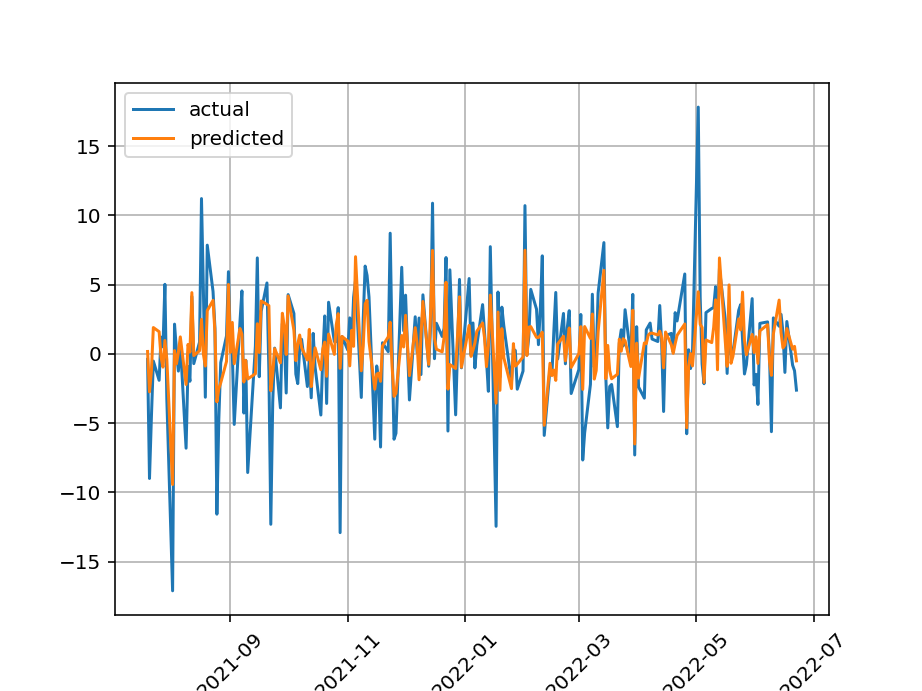

In [38]:
%matplotlib notebook
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

signal_model = RandomForestRegressor()
signal_model.fit(X_train, y_train)

# Test
def test_model(model, X_test, y_test):
    # Predict
    y_predicted = model.predict(X_test)
    # Error and % correct
    loss = np.mean(np.square(y_predicted - y_test))
    correct = ((y_predicted > 0) == (y_test > 0)).sum() / len(y_predicted) * 100
    up = (y_test > 0).sum() / len(y_test) * 100
    print(f'Correctly predicted direction of change {correct}% of the time')
    print(f'Up {up}% of the time')
    print('MSE Loss:', loss)
    print(f'Standard deviation: actual = {np.std(y_test)}, predicted = {np.std(y_predicted)}')
    
    
    predicted_dates = Xy_test_date.apply(lambda dt: dt + timedelta(days=tsigs.predict_window))
    # Plot of percent change
    y_test = tsigs.y_scaler.inverse_transform(y_test.reshape(-1, 1))[:, 0]
    y_predicted = tsigs.y_scaler.inverse_transform(y_predicted.reshape(-1, 1))[:, 0]
    fig, ax=plt.subplots(dpi=72*2)
    ax.plot(predicted_dates, y_test, label="actual")
    ax.plot(predicted_dates, y_predicted, label="predicted")
    plt.xticks(rotation=45)
    plt.grid()
    ax.legend()
    plt.show()

test_model(signal_model, X_test, y_test)

Mean % change: 1.7403548653053542
Total % change: 12.18248405713748


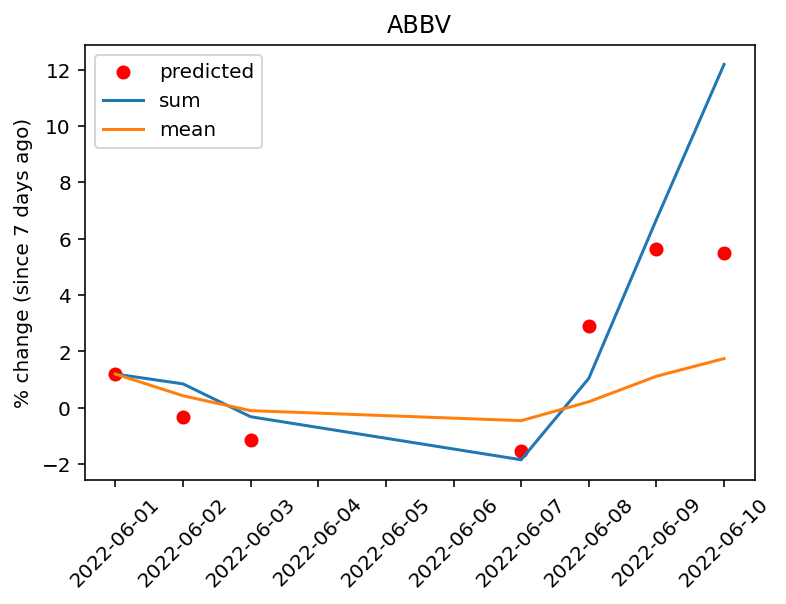

0      -3.616175
1      -2.124610
2       0.610640
3       3.134074
4       8.039155
          ...   
2368         NaN
2369         NaN
2370         NaN
2371         NaN
2372         NaN
Name: pchange_7day, Length: 2373, dtype: float64

In [42]:
def moving_average(a):
    return np.cumsum(a, dtype=float) / np.arange(1, a.shape[0]+1)

def predict_future_changes(model, tsigs):
    # Find rows where the label is nan
    # TODO find a better way, not mutable
    oldsigs = tsigs.signals
    tsigs.signals = tsigs.signals[np.isnan(tsigs.signals[tsigs.label_key])]
    X, date = tsigs.toX()
    # predict
    y_predicted = model.predict(X)
    # scale
    y_predicted = tsigs.y_scaler.inverse_transform(y_predicted.reshape(-1, 1))[:, 0]
    
    predicted_dates = date.apply(lambda dt: dt + timedelta(days=tsigs.predict_window))
    
    print(f'Mean % change: {np.mean(y_predicted)}')
    print(f'Total % change: {np.sum(y_predicted)}')
    # Plot of percent change
    fig, ax=plt.subplots(dpi=72*2)
    ax.scatter(predicted_dates, y_predicted, label="predicted", color="red")
    ax.plot(predicted_dates, np.cumsum(y_predicted), label="sum")
    ax.plot(predicted_dates, moving_average(y_predicted), label="mean")
    plt.title(ticker)
    plt.ylabel(f"% change (since {tsigs.predict_window} days ago)")
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()
    # XXX reset mutable changes at top
    tsigs.signals = oldsigs
    
predict_future_changes(signal_model, tsigs)
tsigs.signals[tsigs.label_key]

Latest data: 2022-06-03 00:00:00
2343   2022-04-22
2344   2022-04-25
2345   2022-04-26
2346   2022-04-27
2347   2022-04-28
2348   2022-04-29
2349   2022-05-02
2350   2022-05-03
2351   2022-05-04
2352   2022-05-05
2353   2022-05-06
2354   2022-05-09
2355   2022-05-10
2356   2022-05-11
2357   2022-05-12
2358   2022-05-13
2359   2022-05-16
2360   2022-05-17
2361   2022-05-18
2362   2022-05-19
2363   2022-05-20
2364   2022-05-23
2365   2022-05-24
2366   2022-05-25
2367   2022-05-26
2368   2022-05-27
2369   2022-05-31
2370   2022-06-01
2371   2022-06-02
2372   2022-06-03
Name: date, dtype: datetime64[ns]
2343   2022-05-22
2344   2022-05-25
2345   2022-05-26
2346   2022-05-27
2347   2022-05-28
2348   2022-05-29
2349   2022-06-01
2350   2022-06-02
2351   2022-06-03
2352   2022-06-04
2353   2022-06-05
2354   2022-06-08
2355   2022-06-09
2356   2022-06-10
2357   2022-06-11
2358   2022-06-12
2359   2022-06-15
2360   2022-06-16
2361   2022-06-17
2362   2022-06-18
2363   2022-06-19
2364   2022-06-

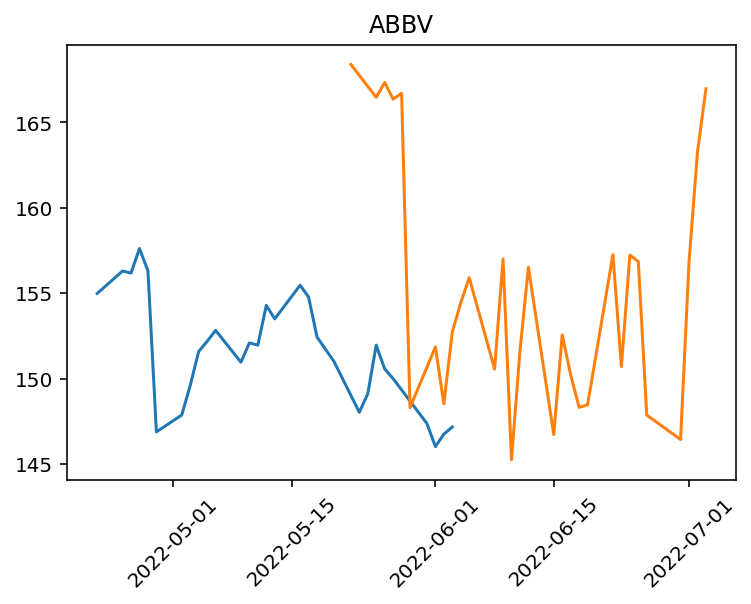

In [35]:
# NOT CORRECT
# This model is not designed to predict prices. This code attempts
# to force the output into specific prices, but it doesn't always
# make sense.
from datetime import timedelta

def predict_future_prices(model, data, tsigs):
    # Find rows where the label is nan
    # TODO find a better way, not mutable
    oldsigs = tsigs.signals
    tsigs.signals = tsigs.signals[np.isnan(tsigs.signals[tsigs.label_key])]
    X, date = tsigs.toX()
    # predict
    y_predicted = model.predict(X)
    # scale
    y_predicted = tsigs.y_scaler.inverse_transform(y_predicted.reshape(-1, 1))[:, 0]
    
    # Compute actual predicted prices
    n = tsigs.predict_window
    n_days_ago = data["close"].to_numpy()[-n:]
    predicted_prices = n_days_ago + y_predicted * 0.01 * n_days_ago
    print(date)
    
    predicted_dates = date.apply(lambda dt: dt + timedelta(days=n))
    print(predicted_dates)

    # Plot of percent change
    fig, ax=plt.subplots(dpi=72*2)
    ax.plot(date, n_days_ago, label="previous")
    ax.plot(predicted_dates, predicted_prices, label="predicted")
    plt.title(ticker)
    plt.xticks(rotation=45)
    plt.show()
    # XXX reset mutable changes at top
    tsigs.signals = oldsigs

print(f'Latest data: {data.iloc[-1]["date"]}')
predict_future_prices(signal_model, data, tsigs)

## Conclusion

This model is excellent for predicting whether the price of an asset will go up or down, from a week to months out. Trying to pull out specific price data from this model would be difficult, but the raw output is actionable in itself.